# LoRA 样例脚本

## 第一步：安装

安装 Data-Juicer 和 DiffSynth-Studio

In [1]:
import os
!pip install --upgrade pip
!pip install simple-aesthetics-predictor
!git clone https://github.com/modelscope/data-juicer.git
!pip install -v -e data-juicer

!pip uninstall pytorch-lightning -y
!pip install peft lightning pandas torchvision
!git clone https://github.com/modelscope/DiffSynth-Studio.git
!pip install -e DiffSynth-Studio

Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
正克隆到 'data-juicer'...
remote: Enumerating objects: 8567, done.
remote: Counting objects: 100% (3450/3450), done.
remote: Compressing objects: 100% (1376/1376), done.
remote: Total 8567 (delta 2701), reused 2382 (delta 2064), pack-reused 5117
接收对象中: 100% (8567/8567), 35.70 MiB | 15.03 MiB/s, 完成.
处理 delta 中: 100% (6241/6241), 完成.
Using pip 23.0.1 from /usr/local/lib/python3.10/site-packages/pip (python 3.10)
Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple
Obtaining file:///mnt/workspace/data-juicer
  Running command python setup.py egg_info
  /usr/local/lib/python3.10/site-packages/_distutils_hack/__init__.py:55: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and a

# 请在这里手动重启 Notebook kernel

## 第二步：下载数据集

In [1]:
from modelscope.msdatasets import MsDataset

ds = MsDataset.load(
    'AI-ModelScope/lowres_anime',
    subset_name='default',
    split='train',
    cache_dir="/mnt/workspace/data"
)

2024-08-09 20:02:55,060 - modelscope - INFO - Downloading to /mnt/workspace/.cache/modelscope/hub/datasets/456b54d723b66c5cf9ae05546bf9cc7b1a64f49ea3cd7720b6313abfbe3e33cc.incomplete


2024-08-09 20:02:55,413 - modelscope - INFO - storing https://www.modelscope.cn/api/v1/datasets/AI-ModelScope/lowres_anime/repo?Source=SDK&Revision=master&FilePath=README.md&View=False in cache at /mnt/workspace/.cache/modelscope/hub/datasets/456b54d723b66c5cf9ae05546bf9cc7b1a64f49ea3cd7720b6313abfbe3e33cc
2024-08-09 20:02:55,414 - modelscope - INFO - creating metadata file for /mnt/workspace/.cache/modelscope/hub/datasets/456b54d723b66c5cf9ae05546bf9cc7b1a64f49ea3cd7720b6313abfbe3e33cc
2024-08-09 20:02:58,458 - modelscope - INFO - Downloading to /mnt/workspace/data/downloads/17d3c758141ec17b93ca84dda7a9c86c03803d434493e6b1f2f6dfd937550474.incomplete


2024-08-09 20:03:07,974 - modelscope - INFO - storing https://www.modelscope.cn/api/v1/datasets/AI-ModelScope/lowres_anime/repo?Source=SDK&Revision=master&FilePath=data%2Ftrain-00000-of-00002.parquet in cache at /mnt/workspace/data/downloads/17d3c758141ec17b93ca84dda7a9c86c03803d434493e6b1f2f6dfd937550474
2024-08-09 20:03:07,975 - modelscope - INFO - creating metadata file for /mnt/workspace/data/downloads/17d3c758141ec17b93ca84dda7a9c86c03803d434493e6b1f2f6dfd937550474
2024-08-09 20:03:08,602 - modelscope - INFO - Downloading to /mnt/workspace/data/downloads/ecae1781fabb900182e642ae22ce701be19aa86177d1fa8684d3d07f2b284c9c.incomplete


2024-08-09 20:03:16,494 - modelscope - INFO - storing https://www.modelscope.cn/api/v1/datasets/AI-ModelScope/lowres_anime/repo?Source=SDK&Revision=master&FilePath=data%2Ftrain-00001-of-00002.parquet in cache at /mnt/workspace/data/downloads/ecae1781fabb900182e642ae22ce701be19aa86177d1fa8684d3d07f2b284c9c
2024-08-09 20:03:16,495 - modelscope - INFO - creating metadata file for /mnt/workspace/data/downloads/ecae1781fabb900182e642ae22ce701be19aa86177d1fa8684d3d07f2b284c9c


Generating train split:   0%|          | 0/1454 [00:00<?, ? examples/s]

保存数据集中的图片及元数据

In [2]:
import json, os
from data_juicer.utils.mm_utils import SpecialTokens
from tqdm import tqdm


os.makedirs("./data/lora_dataset/train", exist_ok=True)
os.makedirs("./data/data-juicer/input", exist_ok=True)
with open("./data/data-juicer/input/metadata.jsonl", "w") as f:
    for data_id, data in enumerate(tqdm(ds)):
        image = data["image"].convert("RGB")
        image.save(f"/mnt/workspace/data/lora_dataset/train/{data_id}.jpg")
        metadata = {"text": "二次元", "image": [f"/mnt/workspace/data/lora_dataset/train/{data_id}.jpg"]}
        f.write(json.dumps(metadata))
        f.write("\n")

100%|██████████| 1454/1454 [00:23<00:00, 61.67it/s] 


## 第三步：数据处理

使用 data-juicer 处理数据

In [3]:
data_juicer_config = """
# global parameters
project_name: 'data-process'
dataset_path: './data/data-juicer/input/metadata.jsonl'  # path to your dataset directory or file
np: 4  # number of subprocess to process your dataset

text_keys: 'text'
image_key: 'image'
image_special_token: '<__dj__image>'

export_path: './data/data-juicer/output/result.jsonl'

# process schedule
# a list of several process operators with their arguments
process:
    - image_shape_filter:
        min_width: 1024
        min_height: 1024
        any_or_all: any
    - image_aspect_ratio_filter:
        min_ratio: 0.5
        max_ratio: 2.0
        any_or_all: any
"""
with open("data/data-juicer/data_juicer_config.yaml", "w") as file:
    file.write(data_juicer_config.strip())

!dj-process --config data/data-juicer/data_juicer_config.yaml

2024-08-09 20:03:56.225267: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 20:03:56.883352: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-09 20:03:58.057519: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-09 20:03:58.715032: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://g

保存处理好的数据

In [4]:
import pandas as pd
import os, json
from PIL import Image
from tqdm import tqdm


texts, file_names = [], []
os.makedirs("./data/lora_dataset_processed/train", exist_ok=True)
with open("./data/data-juicer/output/result.jsonl", "r") as file:
    for data_id, data in enumerate(tqdm(file.readlines())):
        data = json.loads(data)
        text = data["text"]
        texts.append(text)
        image = Image.open(data["image"][0])
        image_path = f"./data/lora_dataset_processed/train/{data_id}.jpg"
        image.save(image_path)
        file_names.append(f"{data_id}.jpg")
data_frame = pd.DataFrame()
data_frame["file_name"] = file_names
data_frame["text"] = texts
data_frame.to_csv("./data/lora_dataset_processed/train/metadata.csv", index=False, encoding="utf-8-sig")
data_frame

100%|██████████| 129/129 [00:04<00:00, 31.02it/s]


file_name text
0       0.jpg  二次元
1       1.jpg  二次元
2       2.jpg  二次元
3       3.jpg  二次元
4       4.jpg  二次元
..        ...  ...
124   124.jpg  二次元
125   125.jpg  二次元
126   126.jpg  二次元
127   127.jpg  二次元
128   128.jpg  二次元

[129 rows x 2 columns]

## 第四步：训练模型

下载模型

In [5]:
from diffsynth import download_models

download_models(["Kolors", "SDXL-vae-fp16-fix"])

2024-08-09 20:04:53.616910: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 20:04:53.650301: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-09 20:04:54.343829: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Failed to load cpm_kernels:No module named 'cpm_kernels'


    Start downloading models/kolors/Kolors/text_encoder/config.json


Downloading: 100%|██████████| 1.29k/1.29k [00:00<00:00, 2.35kB/s]


    Start downloading models/kolors/Kolors/text_encoder/pytorch_model.bin.index.json


Downloading: 100%|██████████| 20.0k/20.0k [00:00<00:00, 35.7kB/s]


    Start downloading models/kolors/Kolors/text_encoder/pytorch_model-00001-of-00007.bin


Downloading: 100%|██████████| 1.70G/1.70G [00:04<00:00, 404MB/s] 


    Start downloading models/kolors/Kolors/text_encoder/pytorch_model-00002-of-00007.bin


Downloading: 100%|██████████| 1.83G/1.83G [00:05<00:00, 360MB/s] 


    Start downloading models/kolors/Kolors/text_encoder/pytorch_model-00003-of-00007.bin


Downloading: 100%|██████████| 1.80G/1.80G [00:05<00:00, 366MB/s] 


    Start downloading models/kolors/Kolors/text_encoder/pytorch_model-00004-of-00007.bin


Downloading: 100%|██████████| 1.69G/1.69G [00:05<00:00, 304MB/s] 


    Start downloading models/kolors/Kolors/text_encoder/pytorch_model-00005-of-00007.bin


Downloading: 100%|██████████| 1.83G/1.83G [00:05<00:00, 348MB/s] 


    Start downloading models/kolors/Kolors/text_encoder/pytorch_model-00006-of-00007.bin


Downloading: 100%|██████████| 1.80G/1.80G [00:05<00:00, 348MB/s] 


    Start downloading models/kolors/Kolors/text_encoder/pytorch_model-00007-of-00007.bin


Downloading: 100%|██████████| 0.98G/0.98G [00:03<00:00, 340MB/s] 


    Start downloading models/kolors/Kolors/unet/diffusion_pytorch_model.safetensors


Downloading: 100%|██████████| 9.61G/9.61G [00:25<00:00, 401MB/s]   


    Start downloading models/kolors/Kolors/vae/diffusion_pytorch_model.safetensors


Downloading: 100%|██████████| 319M/319M [00:01<00:00, 201MB/s]  


    Start downloading models/sdxl-vae-fp16-fix/diffusion_pytorch_model.safetensors


Downloading: 100%|██████████| 319M/319M [00:02<00:00, 121MB/s]  


['models/kolors/Kolors/text_encoder/config.json',
 'models/kolors/Kolors/text_encoder/pytorch_model.bin.index.json',
 'models/kolors/Kolors/text_encoder/pytorch_model-00001-of-00007.bin',
 'models/kolors/Kolors/text_encoder/pytorch_model-00002-of-00007.bin',
 'models/kolors/Kolors/text_encoder/pytorch_model-00003-of-00007.bin',
 'models/kolors/Kolors/text_encoder/pytorch_model-00004-of-00007.bin',
 'models/kolors/Kolors/text_encoder/pytorch_model-00005-of-00007.bin',
 'models/kolors/Kolors/text_encoder/pytorch_model-00006-of-00007.bin',
 'models/kolors/Kolors/text_encoder/pytorch_model-00007-of-00007.bin',
 'models/kolors/Kolors/unet/diffusion_pytorch_model.safetensors',
 'models/kolors/Kolors/vae/diffusion_pytorch_model.safetensors',
 'models/sdxl-vae-fp16-fix/diffusion_pytorch_model.safetensors']

查看训练脚本的输入参数

In [6]:
!python DiffSynth-Studio/examples/train/kolors/train_kolors_lora.py -h

2024-08-09 20:07:30.786379: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 20:07:30.828819: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-09 20:07:31.674209: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Failed to load cpm_kernels:No module named 'cpm_kernels'
/usr/local/lib/python3.10/site-packages/_distutils_hack/__init__.py:55: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils modu

开始训练

提示：

1. 在训练命令中填入 `--modelscope_model_id xxxxx` 以及 `--modelscope_access_token xxxxx` 后，训练程序会在结束时自动上传模型到 ModelScope
2. 部分参数可根据实际需求调整，例如 `lora_rank` 可以控制 LoRA 模型的参数量

In [7]:
import os

cmd = """
python DiffSynth-Studio/examples/train/kolors/train_kolors_lora.py \
  --pretrained_unet_path models/kolors/Kolors/unet/diffusion_pytorch_model.safetensors \
  --pretrained_text_encoder_path models/kolors/Kolors/text_encoder \
  --pretrained_fp16_vae_path models/sdxl-vae-fp16-fix/diffusion_pytorch_model.safetensors \
  --lora_rank 16 \
  --lora_alpha 4.0 \
  --dataset_path data/lora_dataset_processed \
  --output_path ./models \
  --max_epochs 1 \
  --center_crop \
  --use_gradient_checkpointing \
  --precision "16-mixed" \
  --modelscope_model_id "lily2745907300/AIGCtask1" \
  --modelscope_access_token ZTxSUNZozy1oF5Tj3PzW
""".strip()

os.system(cmd)

2024-08-09 20:08:32.900133: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 20:08:32.939967: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-09 20:08:33.686438: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Failed to load cpm_kernels:No module named 'cpm_kernels'
/usr/local/lib/python3.10/site-packages/_distutils_hack/__init__.py:55: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils modu

Loading models from: models/kolors/Kolors/unet/diffusion_pytorch_model.safetensors
    model_name: sdxl_unet model_class: SDXLUNet
        This model is initialized with extra kwargs: {'is_kolors': True}
    The following models are loaded: ['sdxl_unet'].
Loading models from: models/kolors/Kolors/text_encoder


Loading checkpoint shards: 100%|██████████| 7/7 [00:33<00:00,  4.79s/it]
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A10') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type              | Params | Mode
--------------------------------------------------
0 | pipe | SDXLImagePipeline | 8.9 B  | eval
--------------------------------------------------
23.2 M    Trainable params
8.9 B     Non-trainable params
8.9 B     Total params
35,719.684Total estimated model params size (MB)
6457      Modules in train mode
507       Modules i

    The following models are loaded: ['kolors_text_encoder'].
Loading models from: models/sdxl-vae-fp16-fix/diffusion_pytorch_model.safetensors
    model_name: sdxl_vae_encoder model_class: SDXLVAEEncoder
        This model is initialized with extra kwargs: {'upcast_to_float32': True}
    model_name: sdxl_vae_decoder model_class: SDXLVAEDecoder
        This model is initialized with extra kwargs: {'upcast_to_float32': True}
    The following models are loaded: ['sdxl_vae_encoder', 'sdxl_vae_decoder'].
No sdxl_text_encoder models available.
No sdxl_text_encoder_2 models available.
Using kolors_text_encoder from models/kolors/Kolors/text_encoder.
Using sdxl_unet from models/kolors/Kolors/unet/diffusion_pytorch_model.safetensors.
Using sdxl_vae_decoder from models/sdxl-vae-fp16-fix/diffusion_pytorch_model.safetensors.
Using sdxl_vae_encoder from models/sdxl-vae-fp16-fix/diffusion_pytorch_model.safetensors.
No sdxl_ipadapter models available.
No sdxl_ipadapter_clip_image_encoder models ava

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 500/500 [08:46<00:00,  0.95it/s, v_num=0, train_loss=0.0101]
Uploading models to modelscope. model_id: lily2745907300/AIGCtask1 local_path: models/lightning_logs/version_0


Traceback (most recent call last):
  File "/mnt/workspace/DiffSynth-Studio/examples/train/kolors/train_kolors_lora.py", line 77, in <module>
    launch_training_task(model, args)
  File "/mnt/workspace/DiffSynth-Studio/diffsynth/trainers/text_to_image.py", line 252, in launch_training_task
    api.login(args.modelscope_access_token)
  File "/usr/local/lib/python3.10/site-packages/modelscope/hub/api.py", line 114, in login
    raise_for_http_status(r)
  File "/usr/local/lib/python3.10/site-packages/modelscope/hub/errors.py", line 199, in raise_for_http_status
    raise HTTPError(http_error_msg, response=rsp)
requests.exceptions.HTTPError: 400 Client Error: Bad Request, Request id: 810b148bb95140a8b6ae547822047f7a for url: https://www.modelscope.cn/api/v1/login, body: b'{"AccessToken": "ZTxSUNZozy1oF5Tj3PzW"}'


256

加载模型

In [8]:
from diffsynth import ModelManager, SDXLImagePipeline
from peft import LoraConfig, inject_adapter_in_model
import torch


def load_lora(model, lora_rank, lora_alpha, lora_path):
    lora_config = LoraConfig(
        r=lora_rank,
        lora_alpha=lora_alpha,
        init_lora_weights="gaussian",
        target_modules=["to_q", "to_k", "to_v", "to_out"],
    )
    model = inject_adapter_in_model(lora_config, model)
    state_dict = torch.load(lora_path, map_location="cpu")
    model.load_state_dict(state_dict, strict=False)
    return model


# Load models
model_manager = ModelManager(torch_dtype=torch.float16, device="cuda",
                             file_path_list=[
                                 "models/kolors/Kolors/text_encoder",
                                 "models/kolors/Kolors/unet/diffusion_pytorch_model.safetensors",
                                 "models/kolors/Kolors/vae/diffusion_pytorch_model.safetensors"
                             ])
pipe = SDXLImagePipeline.from_model_manager(model_manager)

# Load LoRA
pipe.unet = load_lora(
    pipe.unet,
    lora_rank=16, # This parameter should be consistent with that in your training script.
    lora_alpha=2.0, # lora_alpha can control the weight of LoRA.
    lora_path="models/lightning_logs/version_0/checkpoints/epoch=0-step=500.ckpt"
)

/usr/local/lib/python3.10/site-packages/_distutils_hack/__init__.py:55: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


Loading models from: models/kolors/Kolors/text_encoder


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

    The following models are loaded: ['kolors_text_encoder'].
Loading models from: models/kolors/Kolors/unet/diffusion_pytorch_model.safetensors
    model_name: sdxl_unet model_class: SDXLUNet
        This model is initialized with extra kwargs: {'is_kolors': True}
    The following models are loaded: ['sdxl_unet'].
Loading models from: models/kolors/Kolors/vae/diffusion_pytorch_model.safetensors
    model_name: sdxl_vae_encoder model_class: SDXLVAEEncoder
        This model is initialized with extra kwargs: {'upcast_to_float32': True}
    model_name: sdxl_vae_decoder model_class: SDXLVAEDecoder
        This model is initialized with extra kwargs: {'upcast_to_float32': True}
    The following models are loaded: ['sdxl_vae_encoder', 'sdxl_vae_decoder'].
No sdxl_text_encoder models available.
No sdxl_text_encoder_2 models available.
Using kolors_text_encoder from models/kolors/Kolors/text_encoder.
Using sdxl_unet from models/kolors/Kolors/unet/diffusion_pytorch_model.safetensors.
Using s

生成图像

In [9]:
torch.manual_seed(0)
image = pipe(
    prompt="二次元，一个紫色短发小女孩，在家中沙发上坐着，双手托着腮，很无聊，全身，粉色连衣裙",
    negative_prompt="丑陋、变形、嘈杂、模糊、低对比度",
    cfg_scale=4,
    num_inference_steps=50, height=1024, width=1024,
)
image.save("1.jpg")

100%|██████████| 50/50 [00:20<00:00,  2.49it/s]


In [10]:
torch.manual_seed(1)
image = pipe(
    prompt="二次元，日系动漫，演唱会的观众席，人山人海，一个紫色短发小女孩穿着粉色吊带漏肩连衣裙坐在演唱会的观众席，舞台上衣着华丽的歌星们在唱歌",
    negative_prompt="丑陋、变形、嘈杂、模糊、低对比度",
    cfg_scale=4,
    num_inference_steps=50, height=1024, width=1024,
)
image.save("2.jpg")

100%|██████████| 50/50 [00:18<00:00,  2.67it/s]


In [11]:
torch.manual_seed(2)
image = pipe(
    prompt="二次元，一个紫色短发小女孩穿着粉色吊带漏肩连衣裙坐在演唱会的观众席，露出憧憬的神情",
    negative_prompt="丑陋、变形、嘈杂、模糊、低对比度，色情擦边",
    cfg_scale=4,
    num_inference_steps=50, height=1024, width=1024,
)
image.save("3.jpg")

100%|██████████| 50/50 [00:18<00:00,  2.64it/s]


In [12]:
torch.manual_seed(5)
image = pipe(
    prompt="二次元，一个紫色短发小女孩穿着粉色吊带漏肩连衣裙，对着流星许愿，闭着眼睛，十指交叉，侧面",
    negative_prompt="丑陋、变形、嘈杂、模糊、低对比度，扭曲的手指，多余的手指",
    cfg_scale=4,
    num_inference_steps=50, height=1024, width=1024,
)
image.save("4.jpg")

100%|██████████| 50/50 [00:18<00:00,  2.65it/s]


In [13]:
torch.manual_seed(0)
image = pipe(
    prompt="二次元，一个紫色中等长度头发小女孩穿着粉色吊带漏肩连衣裙，在练习室练习唱歌",
    negative_prompt="丑陋、变形、嘈杂、模糊、低对比度",
    cfg_scale=4,
    num_inference_steps=50, height=1024, width=1024,
)
image.save("5.jpg")

100%|██████████| 50/50 [00:18<00:00,  2.67it/s]


In [14]:
torch.manual_seed(1)
image = pipe(
    prompt="二次元，一个紫色长发小女孩穿着粉色吊带漏肩连衣裙，在练习室练习唱歌，手持话筒",
    negative_prompt="丑陋、变形、嘈杂、模糊、低对比度",
    cfg_scale=4,
    num_inference_steps=50, height=1024, width=1024,
)
image.save("6.jpg")

100%|██████████| 50/50 [00:18<00:00,  2.68it/s]


In [15]:
torch.manual_seed(7)
image = pipe(
    prompt="二次元，紫色长发少女，穿着黑色连衣裙，试衣间，心情忐忑",
    negative_prompt="丑陋、变形、嘈杂、模糊、低对比度",
    cfg_scale=4,
    num_inference_steps=50, height=1024, width=1024,
)
image.save("7.jpg")

100%|██████████| 50/50 [00:18<00:00,  2.69it/s]


In [16]:
torch.manual_seed(0)
image = pipe(
    prompt="二次元，紫色长发少女，穿着黑色礼服，连衣裙，在台上唱歌",
    negative_prompt="丑陋、变形、嘈杂、模糊、低对比度",
    cfg_scale=4,
    num_inference_steps=50, height=1024, width=1024,
)
image.save("8.jpg")

100%|██████████| 50/50 [00:18<00:00,  2.68it/s]


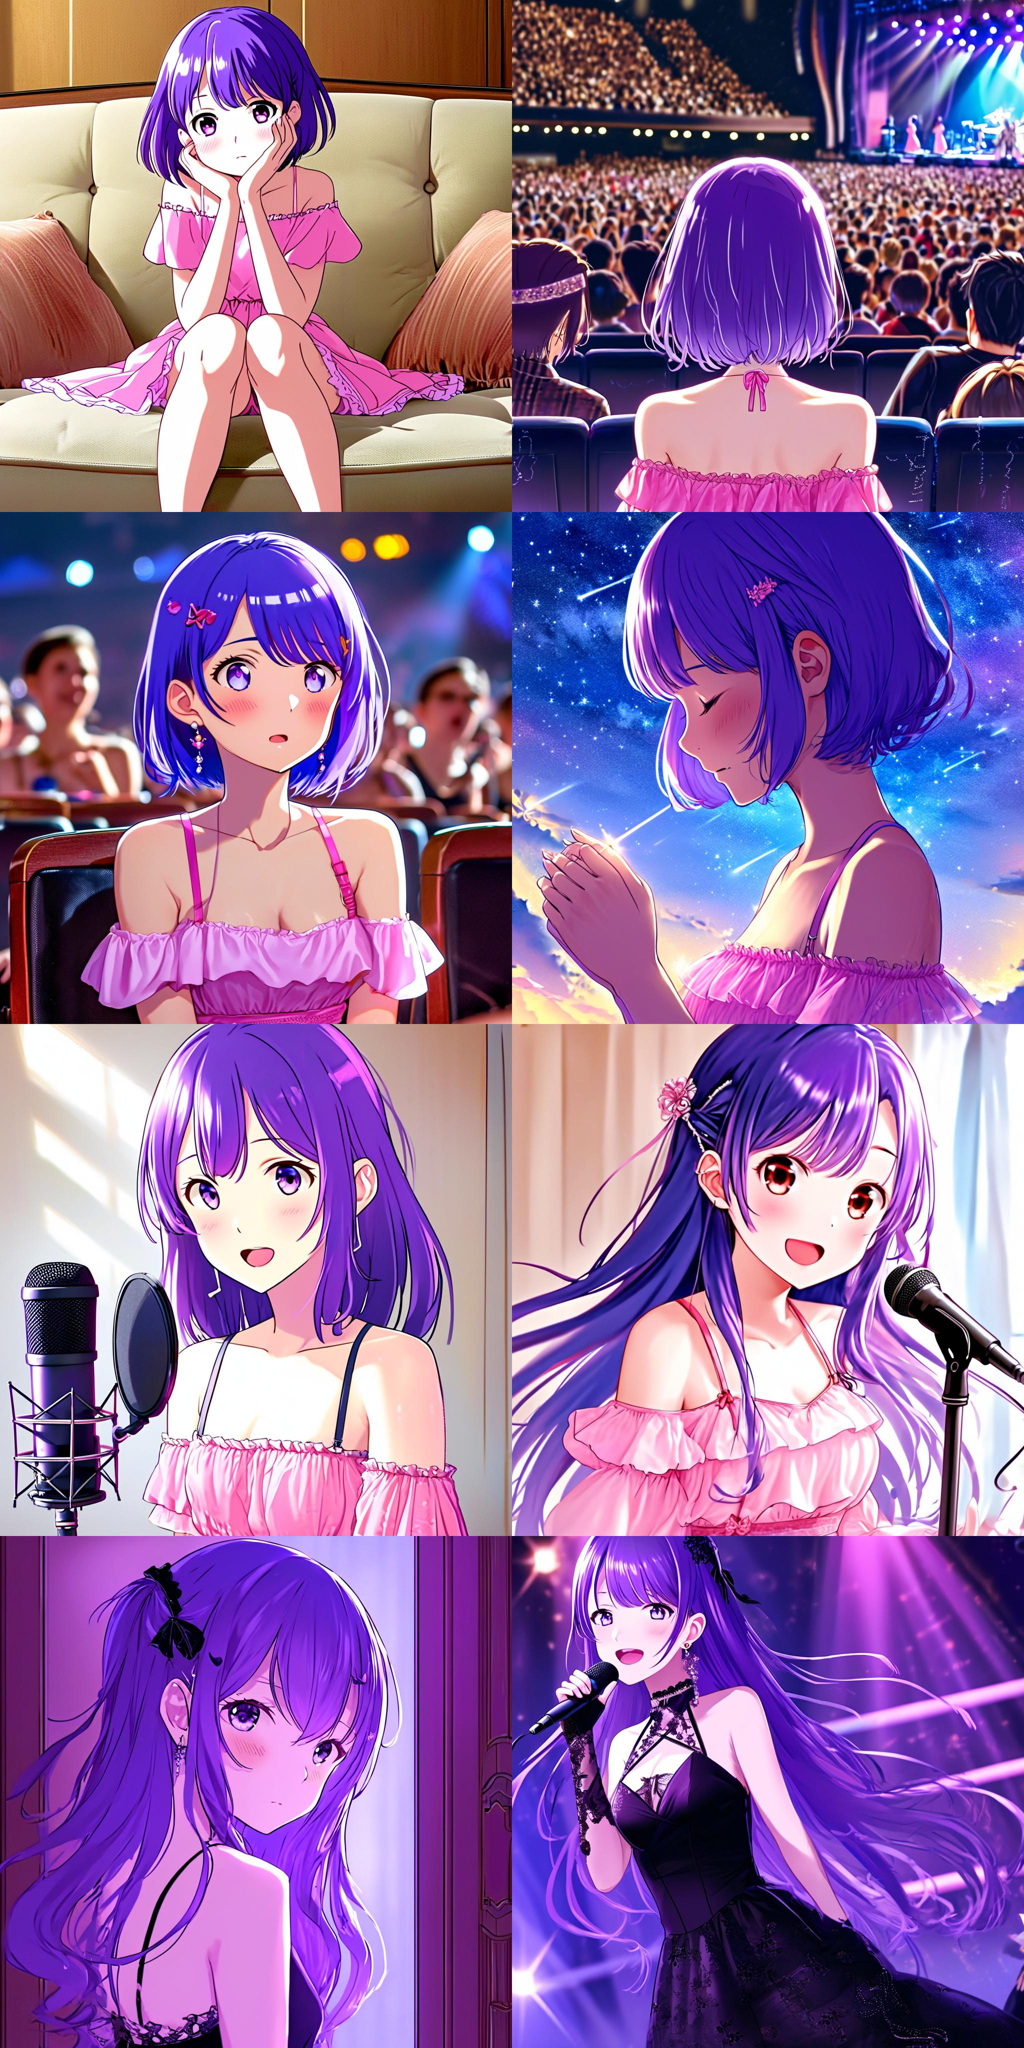

In [17]:
import numpy as np
from PIL import Image


images = [np.array(Image.open(f"{i}.jpg")) for i in range(1, 9)]
image = np.concatenate([
    np.concatenate(images[0:2], axis=1),
    np.concatenate(images[2:4], axis=1),
    np.concatenate(images[4:6], axis=1),
    np.concatenate(images[6:8], axis=1),
], axis=0)
image = Image.fromarray(image).resize((1024, 2048))
image